In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr


from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns


import matplotlib


# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics

In [ ]:
## To do
- get the features listed below
- plot the different square feet things together to see what the relationship is
    - land square feet
    - gross square feet
    - zillow square feet
- try the regression with and without zillow median price
- clean up building_class_category
- run regression
- try feature engineering/scaling

## Model

y - sale price

### Features 
- residential units (done)
- commercial units
- land_square_feet
- gross_square_feet
- zillow square feet
- year_built
- building_class_category (CATEGORY)
- neighborhood OR zip code (CATEGORY)
- time - optional (CATEGORY - grab either month or year)


To Do¶ NEWEST 
-statsmodels OLS - betas and p's
-see if you can do some feature engineering then repeat ^
    -log, square, cube, square root, etc.
    -interaction terms for dummy variables
-do your cross validation stuff (tues + weds)
-then maybe regularization (ridge & lassso) (refer to sean's code)

                                             
                                             #to do
###newdfclean
#Other data to get, public transportation, income by,  crime by 
#categorial: boro, tax code by class, zip-code,
# data= data[data['TAX_CLASS_AT_TIME_OF_SALE'] == 1 or 2]

In [2]:
data=pd.read_excel("rollingsales_manhattan.xls", skiprows=1) #combined excel sheets for 2016-2018

data = data[data['SALE_PRICE'] > 100] #get rid of 0's in sale price 
data = data[data['SALE_PRICE'] < 250000000] #get rid of 0's in sale price 
data=data[data['GROSS SQUARE FEET'] > 100] #get rid of 0s in square foot
data.columns=['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE']
zillow_squarefootage=pd.read_excel("Zip_MedianListingPricePerSqft_AllHomes.xls")
zillow_squarefootage=zillow_squarefootage.loc[:,["RegionName","2018-10"]] 
zillow_squarefootage['ZIP_CODE']=zillow_squarefootage['RegionName']
zillow_squarefootage['ZillowSquareFootage']=zillow_squarefootage['2018-10']

zillow_median_listing=pd.read_excel("Zip_MedianListingPrice_AllHomes.xls")
zillow_median_listing=zillow_median_listing.loc[:,["RegionName","2018-10"]] 
zillow_median_listing['ZIP_CODE']=zillow_median_listing['RegionName']
zillow_median_listing['ZillowMedianPrice']=zillow_median_listing['2018-10']

new_df2= zillow_squarefootage.merge(zillow_median_listing, how = 'inner', on = ['ZIP_CODE'])
# new_df3=new_df2.merge(average_by_zip_2018, how = 'inner', on = ['ZIP_CODE'])
new_df3= data.merge(new_df2, how = 'inner', on = ['ZIP_CODE'])
new_df=new_df3.copy()
new_df=new_df.drop(columns=['RegionName_y', 'RegionName_x',"2018-10_x","2018-10_y"])
# new_df.columns

In [3]:
#Changing the datatype of Median Price and Square Footage from Float to Integer
new_df['ZillowMedianPrice'] = new_df['ZillowMedianPrice'].astype(int)
new_df['ZillowSquareFootage'] = new_df['ZillowSquareFootage'].astype(int)
target=new_df[["SALE_PRICE"]]
features= new_df 

features=features.drop(columns=["SALE_DATE",'BOROUGH',                     
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 
        'TOTAL_UNITS',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
      'SALE_PRICE','ZillowSquareFootage', 'ZillowMedianPrice',]) #maybe drop zillow two 
features["BUILDING_CLASS_CATEGORY"]=features["BUILDING_CLASS_CATEGORY"].str.strip()
features["BUILDING_CLASS_CATEGORY"]=features["BUILDING_CLASS_CATEGORY"].str.replace(' ', '')
#Strip duplicate neighborhood categories
features["NEIGHBORHOOD"]=features["NEIGHBORHOOD"].str.strip()
features["NEIGHBORHOOD"]=features["NEIGHBORHOOD"].str.replace(' ', '')
cat_vars=features[['BUILDING_CLASS_CATEGORY',"NEIGHBORHOOD","ZIP_CODE"]]

In [4]:
# type(data['SALE_PRICE'])
type(data.SALE_PRICE)
data.SALE_PRICE.sort_values(ascending=False)

18929    239114603
24259    237764000
33       219943269
26525    217668000
24273    215200000
18882    212500000
21658    205961801
19350    203345000
55       194535000
25       193000000
26       182925375
18930    182391612
26534    180000000
14       175000000
23451    174000000
74       173926237
33972    172500000
32       167500000
18878    167100000
43       165635985
24257    155000000
54       153000000
21004    153000000
26526    151708000
17769    150000000
18612    148800000
114      147000000
117      145500000
33820    145000000
19778    143000000
           ...    
26662        33900
26639        33900
26638        33900
26786        29370
26891        27275
26831        26825
26826        25356
26906        25000
26905        24570
26657        24000
26545        20682
26608        20600
26889        20379
21799        20000
26661        18000
26788        16493
26611        14182
34361        13864
26851        12600
1597         10713
26610        10000
75          

In [5]:
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(features[var], prefix=var)#,drop_first=True)
    data1=features.join(cat_list)
    features=data1
data_vars=features.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
features=features[to_keep]


/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


skewness: 4.750264
kurtosis: 26.823504


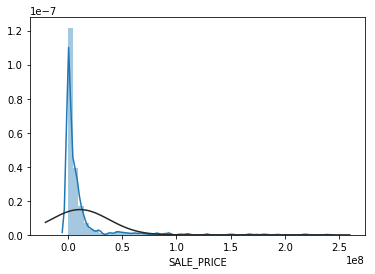

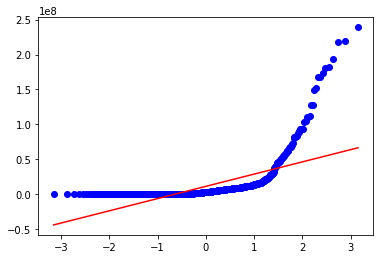

In [6]:
new_df["SALE_PRICE"].describe()
sns.distplot(new_df.SALE_PRICE,fit=norm);
plt.ylabel =('Frequency')
plt.title = ('SalePrice Distribution');
#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(new_df["SALE_PRICE"]);
#QQ plot
fig = plt.figure()
res = stats.probplot(new_df["SALE_PRICE"], plot=plt)
# plt.show()
print("skewness: %f" % new_df["SALE_PRICE"].skew())
print("kurtosis: %f" % new_df["SALE_PRICE"].kurt())

/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


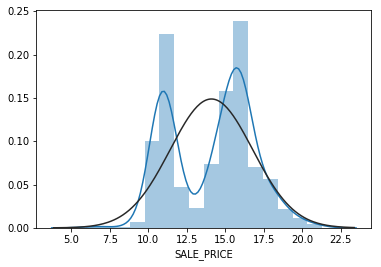

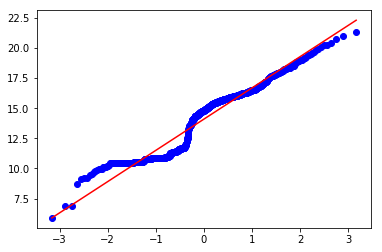

In [59]:
#notes
#Plotted the distribution of the SALE_PRICE and normal probability graph which is used to identify substantive departures from normality. This includes identifying outliers, skewness and kurtosis. Used the QQ-plot
#log transform the target 
new_df["SALE_PRICE"] = np.log1p(new_df["SALE_PRICE"])

#Kernel Density plot
sns.distplot(new_df.SALE_PRICE,fit=norm);
plt.ylabel=('Frequency')
plt.title=('SalePrice distribution');
#Get the fitted parameters used by the function
(mu,sigma)= norm.fit(new_df["SALE_PRICE"]);
#QQ plot
fig =plt.figure()
res =stats. probplot(new_df["SALE_PRICE"], plot=plt)
plt.show()


# # Step 1: Checking for Linearity  using Scatterplots

/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


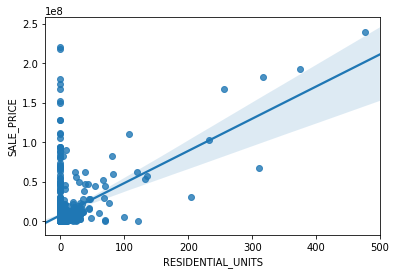

In [7]:

sns.regplot(y=new_df.SALE_PRICE, x=new_df['RESIDENTIAL_UNITS'], data=new_df, fit_reg = True)


/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


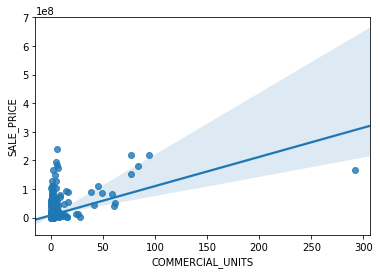

In [8]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['COMMERCIAL_UNITS'], data=new_df, fit_reg = True)



In [ ]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['LAND_SQUARE_FEET'], data=new_df, fit_reg = True)

In [ ]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['GROSS_SQUARE_FEET'], data=new_df, fit_reg = True)


# Graph showing the distribution of prices by neighborhoood

In [ ]:

plt.figure(figsize=(12,7))
sns.stripplot(x = new_df.NEIGHBORHOOD, y = new_df.SALE_PRICE,
              order = np.sort(new_df.NEIGHBORHOOD.unique()),
              jitter=0.1, alpha=0.5)
plt.xticks(rotation=45)




# Distribution of square footage and sale price

In [ ]:

plt.figure(figsize=(12,7))
sns.stripplot(x = new_df.GROSS_SQUARE_FEET, y = new_df.SALE_PRICE,
              order = np.sort(new_df.GROSS_SQUARE_FEET),
              jitter=0.1, alpha=0.5)
plt.xticks(rotation=45)

# Distribution of homes built by year 

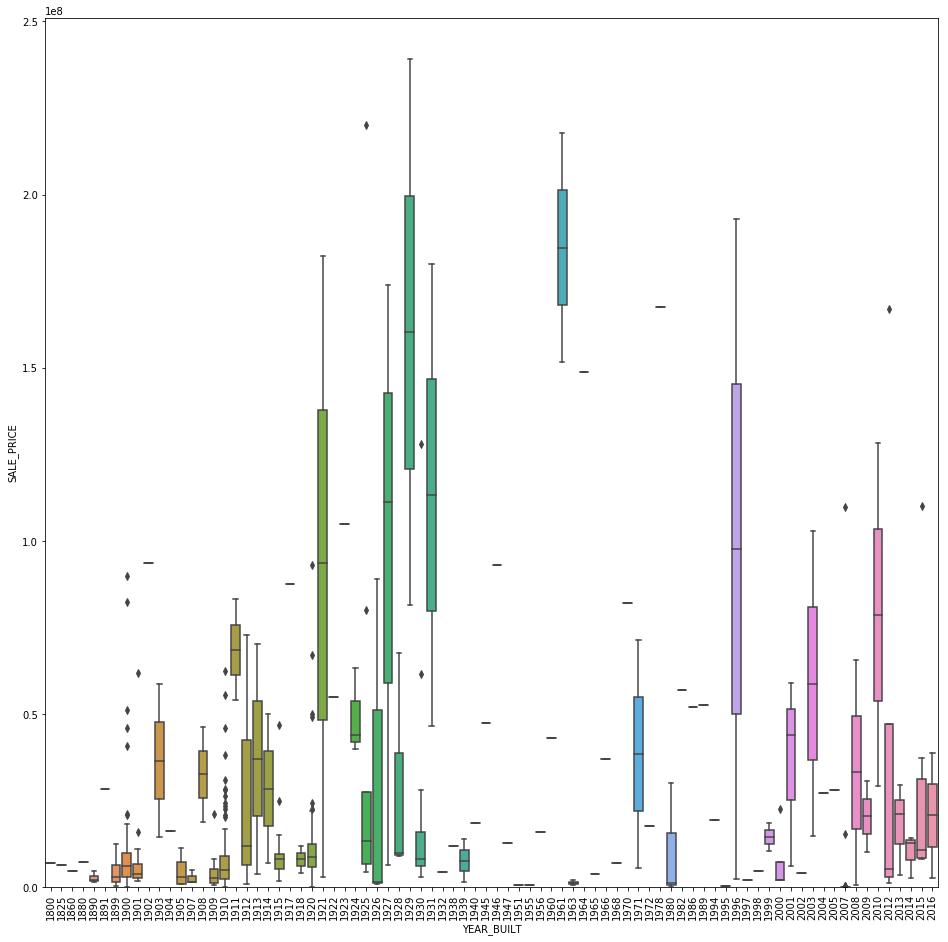

In [9]:
var  = 'YEAR_BUILT'
data= pd.concat([new_df['SALE_PRICE'], new_df[var]], axis =1)
f, ax = plt.subplots(figsize=(16, 16))
fig = sns.boxplot(x=var, y=new_df['SALE_PRICE'], data=data)
fig.axis(ymin=5)
plt.xticks(rotation=90);
plt.show();

# Regression Info Below
# Features described first 

In [10]:

features.describe()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,...,ZIP_CODE_10009,ZIP_CODE_10012,ZIP_CODE_10013,ZIP_CODE_10016,ZIP_CODE_10018,ZIP_CODE_10019,ZIP_CODE_10027,ZIP_CODE_10029,ZIP_CODE_10036,ZIP_CODE_10038
count,866.000000,866.000000,866.000000,8.660000e+02,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,...,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000
mean,9.247113,2.975751,5549.627021,5.932070e+04,1952.683603,0.032333,0.026559,0.021940,0.259815,0.049654,...,0.060046,0.028868,0.080831,0.066975,0.033487,0.420323,0.112009,0.100462,0.025404,0.004619
std,31.859502,12.372564,6301.376164,9.459625e+04,48.081714,0.176984,0.160883,0.146572,0.438787,0.217354,...,0.237710,0.167533,0.272734,0.250122,0.180009,0.493896,0.315560,0.300789,0.157440,0.067845
min,0.000000,0.000000,0.000000,3.360000e+02,1800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2124.250000,6.251500e+03,1910.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,4966.500000,2.035950e+04,1925.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,2.000000,7532.000000,1.128500e+05,2007.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,476.000000,292.000000,80333.000000,1.613847e+06,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Of the 5 original features used [RESIDENTIAL_UNITS, COMMERCIAL_UNITS, LAND_SQUARE_FEET, GROSS_SQUARE_FEET and YEAR_BUILT], only the LAND_SQUARE_FEET had a P value above 0.05. Its value was 0.219

# R^2 total using 4 features = 0.727 

In [11]:
# GROSS_SQUARE_FEET:0.645
# Residential Units: 0.071
# COMMERCIAL_UNITS :0.098
# LAND_SQUARE_FEET:0.534
# YEAR_BUILT:0.000
#ZillowSquareFootage:0.006... pvalue of 0.024
#ZillowMedianPrice0.012...pvalue of 0.001
#ALL WITH ZILLOW: 0.729

m7 = ols('SALE_PRICE ~RESIDENTIAL_UNITS+COMMERCIAL_UNITS+GROSS_SQUARE_FEET+YEAR_BUILT ',new_df).fit()
print(m7.summary())
m1 = ols('SALE_PRICE ~GROSS_SQUARE_FEET',new_df).fit()
print(m1.summary())
# m2 = ols('SALE_PRICE ~RESIDENTIAL_UNITS ',new_df).fit()
# print(m2.summary())
# m3 = ols('SALE_PRICE ~COMMERCIAL_UNITS ',new_df).fit()
# print(m3.summary())
# m4 = ols('SALE_PRICE ~LAND_SQUARE_FEET ',new_df).fit()
# print(m4.summary())
m5 = ols('SALE_PRICE ~GROSS_SQUARE_FEET ',new_df).fit()
print(m5.summary())
# m6 = ols('SALE_PRICE ~YEAR_BUILT ',new_df).fit()
# print(m6.summary())


#####regression for zillow items below 
# m8 = ols('SALE_PRICE ~ZillowSquareFootage ',new_df).fit()
# print(m8.summary())
# m9 = ols('SALE_PRICE ~ZillowMedianPrice ',new_df).fit()
# print(m9.summary())
# m10 = ols('SALE_PRICE ~RESIDENTIAL_UNITS+ZillowSquareFootage+ZillowMedianPrice+COMMERCIAL_UNITS+LAND_SQUARE_FEET+GROSS_SQUARE_FEET+YEAR_BUILT ',new_df).fit()
# print(m10.summary())



                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     265.5
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          1.36e-148
Time:                        09:57:38   Log-Likelihood:                -15693.
No. Observations:                 866   AIC:                         3.140e+04
Df Residuals:                     861   BIC:                         3.142e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.899e+08   2.86e+0

In [12]:
reg = LinearRegression()

In [13]:
train1= features # can change to scaled_features or features to test regresion model with or without categorical values 
labels=target


In [14]:
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.20,random_state =30)

In [15]:
reg.fit(x_train,y_train)
reg.score(x_test,y_test) 
#highest score with all variables (2110) is .79

0.7250078942974849

# #We create a scatterplot between the predicted prices, (where m is the fitted model) and the original prices. 

# A perfect model would get us a scatterplot where all the data lies on the 45 degree line. 

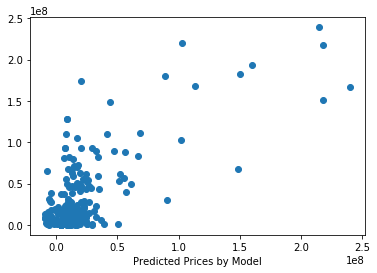

In [17]:
predicted_prices = m7.fittedvalues

plt.scatter(predicted_prices, new_df.SALE_PRICE)
plt.xlabel("Predicted Prices by Model")
plt.ylabel='Original Prices'
plt.title='Predictions vs. Original Prices'
plt.show()



Text(0.5, 0, 'Fitted Values')

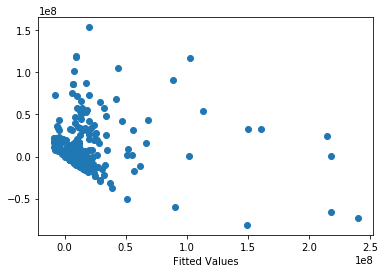

In [18]:
x = m7.fittedvalues
y = m7.resid
plt.scatter(x, y)

plt.xlabel("Fitted Values")
# plt.ylabel("Residual")
# plt.title("Fitted Values vs. Residuals")

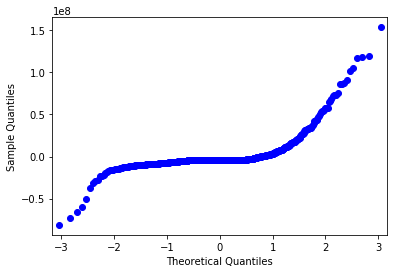

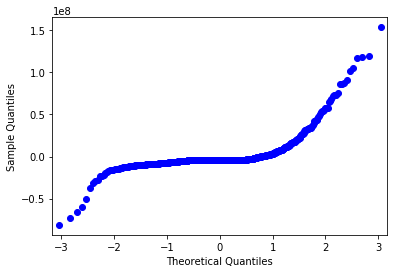

In [19]:
sm.qqplot(m7.resid)

In [20]:
lm = LinearRegression()
lm.fit(x_train,y_train)

# evaluation using r-square

lm.score(x_train,y_train)
# x_test

0.7317281102976905

In [21]:
y_pred = lm.predict(x_test) #from seans ridge nad lasso slides 

print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MSE: 184264415698478.22
RMSE: 13574402.959190441


In [22]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, y_pred)
# sklearn.metrics.median_absolute_error(y_true, y_pred)[source]

1585151.4366711378

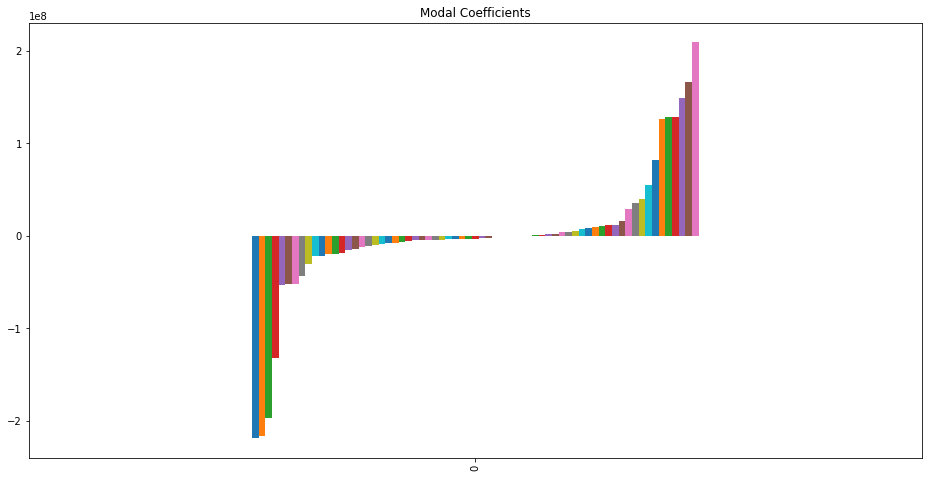

In [82]:
coef = pd.DataFrame(data=lm.coef_, columns=x_train.columns ) #takes co-effficent and pairs up with columns, and looks at 

model_coef = coef.T.sort_values(by=0).T

model_coef.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [146]:
y_test.std()

SALE_PRICE    1.476981e+08
dtype: float64

MSE: 247987123402372.38
RMSE: 15747606.91033315
SALE_PRICE    0.6066
dtype: float64


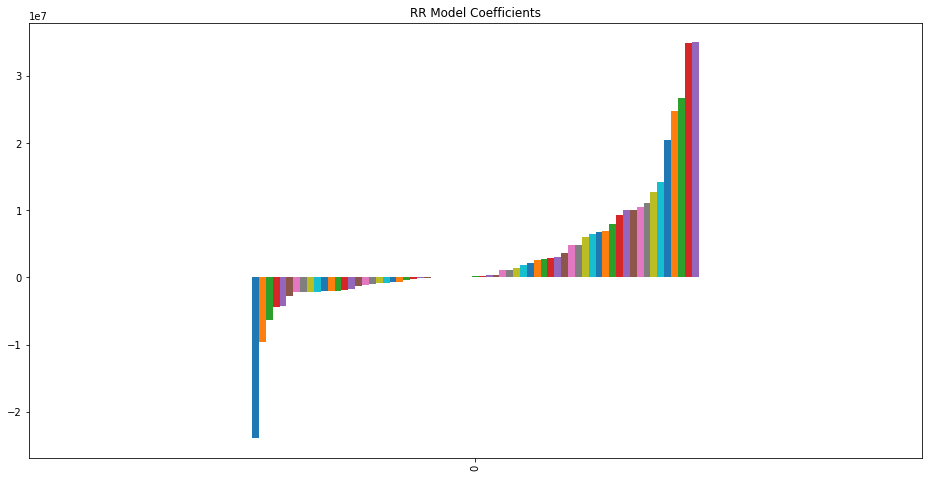

In [23]:
X_train=x_train #***
X_test=x_test
ridgeReg = Ridge(alpha=.50, normalize=True)

ridgeReg.fit(X_train,y_train)

y_pred = ridgeReg.predict(X_test)

#calculating mse

print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ y_test.std())
coef = pd.DataFrame(data=ridgeReg.coef_, columns=X_train.columns )

model_coef = coef.T.sort_values(by=0).T

model_coef.plot(kind='bar', title='RR Model Coefficients', legend=False, figsize=(16,8))

MSE: 3560401194243462.5
RMSE: 59669097.48138866
SALE_PRICE    0.502862
dtype: float64


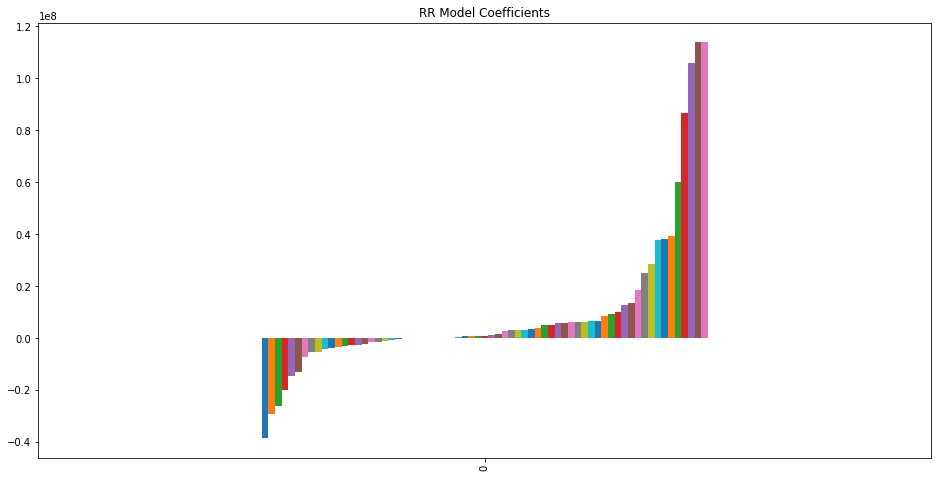

In [73]:
#Identifing Outliers
X_train=x_train #***
X_test=x_test
ridgeReg = Ridge(alpha=.20, normalize=True)

ridgeReg.fit(X_train,y_train)

y_pred = ridgeReg.predict(X_test)

#calculating mse

print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ y_test.std())
coef = pd.DataFrame(data=ridgeReg.coef_, columns=X_train.columns )

model_coef = coef.T.sort_values(by=0).T

model_coef.plot(kind='bar', title='RR Model Coefficients', legend=False, figsize=(16,8))

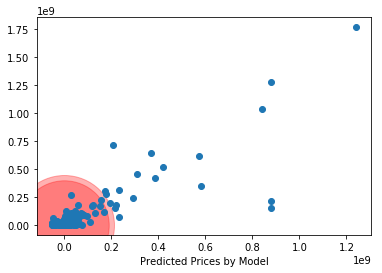

In [54]:
plt.scatter(-0, 25, s=10000, alpha=0.3, c = 'r' )
plt.scatter(45, 21, s=8000, alpha=0.3, c = 'r' )


predicted_prices = m7.fittedvalues

plt.xlabel("Predicted Prices by Model")
# plt.ylabel()
# plt.title("Predictions vs. Original Prices")
plt.scatter(predicted_prices, new_df.SALE_PRICE)


/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


MSE: 3505174801478849.5
RMSE: 59204516.73207754
SALE_PRICE    0.498946
dtype: float64


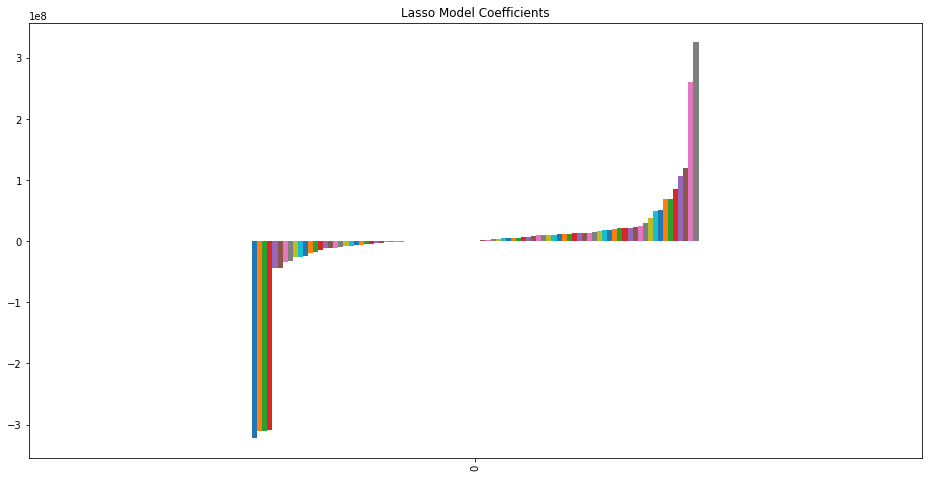

In [55]:
#***Lasso regression not only helps in reducing over-fitting but it can help us in feature selection.
from sklearn.linear_model import Lasso


lassoReg = Lasso(alpha=50, normalize=True)

lassoReg.fit(X_train,y_train)

y_pred = lassoReg.predict(X_test)

#calculating mse

print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ y_test.std())



coef = pd.DataFrame(data=lassoReg.coef_, index=X_train.columns )
model_coef = coef.sort_values(by=0).T

model_coef.plot(kind='bar', title='Lasso Model Coefficients', legend=False, figsize=(16,8))


In [153]:
from sklearn.feature_selection import RFE
rfe = RFE(lm, n_features_to_select=10)
rfe.fit(features_selected_train,y_train)

NameError: name 'features_selected_train' is not defined

/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'House Sales Price Distribution')

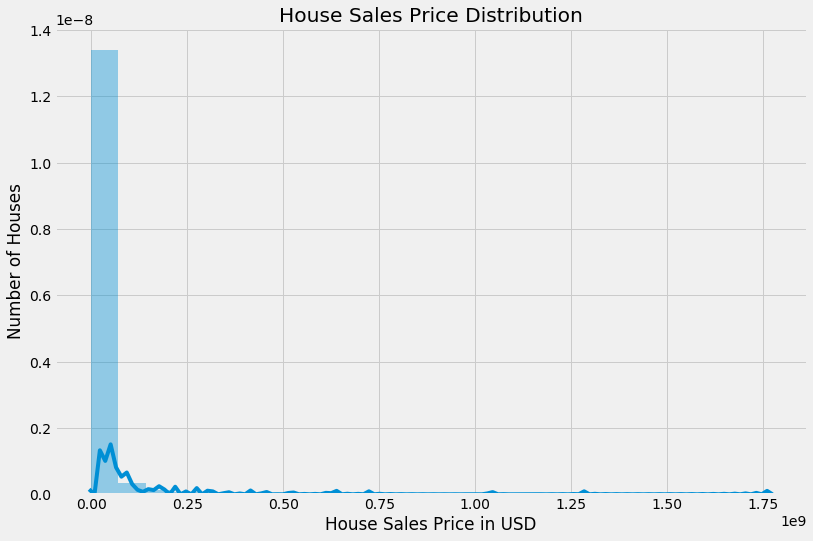

In [90]:

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.distplot(new_df.SALE_PRICE, bins = 25)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")


In [175]:
# x_test

In [199]:
from sklearn import preprocessing
from sklearn import pipeline

scaler = preprocessing.StandardScaler()
X_test=x_test#[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'LAND_SQUARE_FEET','GROSS_SQUARE_FEET', 'YEAR_BUILT']]
X_test1=x_test#[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'LAND_SQUARE_FEET','GROSS_SQUARE_FEET', 'YEAR_BUILT',"BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS"]]
X_test1=x_test[['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'LAND_SQUARE_FEET','GROSS_SQUARE_FEET', 'YEAR_BUILT',"BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS"]]
X_train=x_train

In [200]:
scaler.fit(features.iloc[:,:-1])


/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [201]:
len(X_test1.columns[:-1])
len(X_test1.iloc[:,:-1])
X_test1.columns.shape

(6,)

In [202]:
scaler.fit(X_train.iloc[:,:-1])
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,:-1]), columns=X_train.columns[:-1], index=X_train.index)

features_scaled_train.head()

/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/powersky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,...,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES
650,-0.262871,0.029977,-0.523361,-0.466001,-0.815487,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,-0.107211,-0.779298,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716
814,-0.110075,-0.107060,-0.440319,-0.457601,-0.920281,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,-0.107211,-0.779298,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716
708,-0.186473,-0.244096,-0.547505,-0.460859,-0.920281,-0.187867,-0.161985,7.020379,-0.579537,-0.242171,...,-0.107211,-0.779298,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716
129,-0.262871,-0.107060,0.176702,0.295179,1.112720,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,-0.107211,1.283206,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716
212,-0.262871,-0.107060,0.176702,0.295179,1.112720,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,-0.107211,1.283206,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716


In [203]:
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,:-1]), columns=X_test.columns[:-1], index=X_test.index)

features_scaled_test.head()

/Users/powersky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,...,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES
851,-0.135541,0.098495,0.052932,-0.153865,-1.129868,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,-0.107211,-0.779298,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716
207,-0.262871,-0.107060,0.176702,0.295179,1.112720,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,-0.107211,1.283206,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716
515,-0.059143,-0.175578,-0.531043,-0.455359,-0.605899,-0.187867,-0.161985,-0.142442,1.725515,-0.242171,...,-0.107211,-0.779298,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716
537,-0.262871,-0.107060,-0.019135,0.086056,-0.543023,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,-0.107211,1.283206,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716
728,-0.008211,-0.244096,-0.589453,-0.474996,-0.920281,-0.187867,-0.161985,-0.142442,1.725515,-0.242171,...,-0.107211,-0.779298,-0.075593,-0.065419,-0.037716,-0.053376,-0.037716,-0.037716,-0.125988,-0.037716


In [204]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_64_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
features_64_train.head()


,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,...,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES^2,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_34THEATRES^2,BUILDING_CLASS_CATEGORY_34THEATRES BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES^2,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES^2
0,-0.262871,0.029977,-0.523361,-0.466001,-0.815487,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,0.001422,0.001422,0.004752,0.001422,0.001422,0.004752,0.001422,0.015873,0.004752,0.001422
1,-0.110075,-0.107060,-0.440319,-0.457601,-0.920281,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,0.001422,0.001422,0.004752,0.001422,0.001422,0.004752,0.001422,0.015873,0.004752,0.001422
2,-0.186473,-0.244096,-0.547505,-0.460859,-0.920281,-0.187867,-0.161985,7.020379,-0.579537,-0.242171,...,0.001422,0.001422,0.004752,0.001422,0.001422,0.004752,0.001422,0.015873,0.004752,0.001422
3,-0.262871,-0.107060,0.176702,0.295179,1.112720,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,0.001422,0.001422,0.004752,0.001422,0.001422,0.004752,0.001422,0.015873,0.004752,0.001422
4,-0.262871,-0.107060,0.176702,0.295179,1.112720,-0.187867,-0.161985,-0.142442,-0.579537,-0.242171,...,0.001422,0.001422,0.004752,0.001422,0.001422,0.004752,0.001422,0.015873,0.004752,0.001422


In [207]:
pd.set_option('display.max_columns', 100)
features_64_train.head()
features_64_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))
features_64_test.head()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT,BUILDING_CLASS_CATEGORY_17CONDOCOOPS,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,RESIDENTIAL_UNITS^2,RESIDENTIAL_UNITS COMMERCIAL_UNITS,RESIDENTIAL_UNITS LAND_SQUARE_FEET,RESIDENTIAL_UNITS GROSS_SQUARE_FEET,RESIDENTIAL_UNITS YEAR_BUILT,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_17CONDOCOOPS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_30WAREHOUSES,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,...,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_26OTHERHOTELS^2,BUILDING_CLASS_CATEGORY_26OTHERHOTELS BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_26OTHERHOTELS BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_26OTHERHOTELS BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_26OTHERHOTELS BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_26OTHERHOTELS BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_26OTHERHOTELS BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_26OTHERHOTELS BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_26OTHERHOTELS BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES^2,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES BUILDING_CLASS_CATEGORY_37

In [ ]:
***

In [208]:
from sklearn.feature_selection import VarianceThreshold
thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [210]:
features_selected_train = variance_threshold_selector(features_64_train)
# features_selected_train = variance_threshold_selector(features_64_train)

In [211]:
features_selected_train.head()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,RESIDENTIAL_UNITS^2,RESIDENTIAL_UNITS LAND_SQUARE_FEET,RESIDENTIAL_UNITS GROSS_SQUARE_FEET,RESIDENTIAL_UNITS YEAR_BUILT,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,COMMERCIAL_UNITS^2,COMMERCIAL_UNITS LAND_SQUARE_FEET,COMMERCIAL_UNITS GROSS_SQUARE_FEET,COMMERCIAL_UNITS YEAR_BUILT,COMMERCIAL_UNITS BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,COMMERCIAL_UNITS BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,COMMERCIAL_UNITS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,COMMERCIAL_UNITS BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,LAND_SQUARE_FEET^2,LAND_SQUARE_FEET GROSS_SQUARE_FEET,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_26OTHERHOTELS,...,YEAR_BUILT BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,YEAR_BUILT BUILDING_CLASS_CATEGORY_30WAREHOUSES,YEAR_BUILT BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,YEAR_BUILT BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,YEAR_BUILT BUILDING_CLASS_CATEGORY_34THEATRES,YEAR_BUILT BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,YEAR_BUILT BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS^2,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS^2,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS^2,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS^2,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS^2,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS^2,BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS^2,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT^2,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS^2,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS^2,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS BUILDING_CLAS

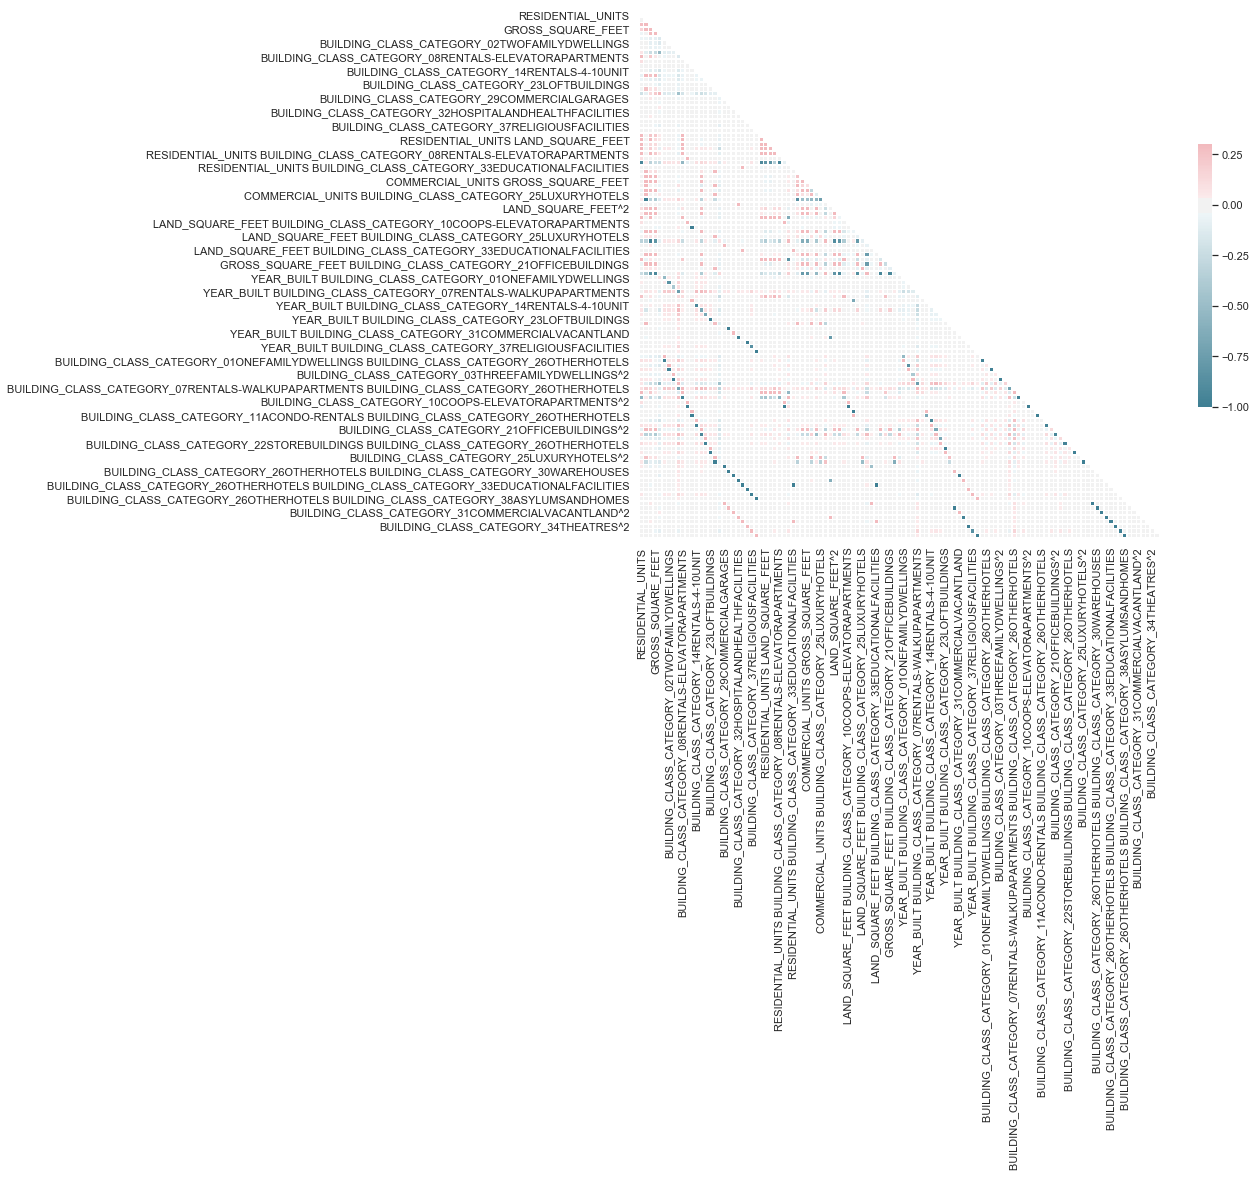

In [212]:
import seaborn as sns

sns.set(style="white")


# Compute the correlation matrix
corr = features_selected_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [213]:
# Create correlation matrix
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [215]:
upper

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,RESIDENTIAL_UNITS^2,RESIDENTIAL_UNITS LAND_SQUARE_FEET,RESIDENTIAL_UNITS GROSS_SQUARE_FEET,RESIDENTIAL_UNITS YEAR_BUILT,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,COMMERCIAL_UNITS^2,COMMERCIAL_UNITS LAND_SQUARE_FEET,COMMERCIAL_UNITS GROSS_SQUARE_FEET,COMMERCIAL_UNITS YEAR_BUILT,COMMERCIAL_UNITS BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,COMMERCIAL_UNITS BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,COMMERCIAL_UNITS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,COMMERCIAL_UNITS BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,LAND_SQUARE_FEET^2,LAND_SQUARE_FEET GROSS_SQUARE_FEET,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_26OTHERHOTELS,...,YEAR_BUILT BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,YEAR_BUILT BUILDING_CLASS_CATEGORY_30WAREHOUSES,YEAR_BUILT BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,YEAR_BUILT BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,YEAR_BUILT BUILDING_CLASS_CATEGORY_34THEATRES,YEAR_BUILT BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,YEAR_BUILT BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS^2,BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS^2,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS^2,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS^2,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS^2,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS^2,BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS^2,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT^2,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS^2,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS^2,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS BUILDING_CLAS

In [216]:
features_selected_train.drop(columns=to_drop, inplace=True)

/Users/powersky/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [217]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [218]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]
test = SelectKBest(score_func=mutual_info_regression, k=30)
fit = test.fit(features_selected_train, y_train)

/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [219]:
features_selected_train[features_selected_train.columns[fit.get_support(indices=True)]].head()

,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,RESIDENTIAL_UNITS LAND_SQUARE_FEET,RESIDENTIAL_UNITS YEAR_BUILT,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,COMMERCIAL_UNITS LAND_SQUARE_FEET,COMMERCIAL_UNITS YEAR_BUILT,LAND_SQUARE_FEET^2,LAND_SQUARE_FEET GROSS_SQUARE_FEET,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,LAND_SQUARE_FEET BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,GROSS_SQUARE_FEET BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,GROSS_SQUARE_FEET BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,GROSS_SQUARE_FEET BUILDING_CLASS_CATEGORY_26OTHERHOTELS,YEAR_BUILT BUILDING_CLASS_CATEGORY_01ONEFAMILYDWELLINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,YEAR_BUILT BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,YEAR_BUILT BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,YEAR_BUILT BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT,YEAR_BUILT BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,YEAR_BUILT BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,YEAR_BUILT BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS BUILDING_CLASS_CATEGORY_26OTHERHOTELS
0,-0.523361,-0.466001,-0.815487,-0.779298,0.137577,0.214368,0.204855,-0.015689,-0.024446,0.273906,0.243887,0.126743,0.056110,0.039562,0.112852,0.049961,0.363154,0.153203,0.132096,0.116160,0.472605,0.197487,0.043527,0.177954,0.232683,-3.737030,0.087429,0.102742,0.451632,0.222357
1,-0.440319,-0.457601,-0.920281,-0.779298,0.048468,0.101300,0.085782,0.047140,0.098525,0.193881,0.201490,0.106632,0.047207,0.033285,0.110818,0.049060,0.356608,0.172891,0.149071,0.131087,0.533337,0.222865,0.049121,-4.217256,0.262584,0.200822,0.098664,0.115944,0.451632,0.222357
2,-0.547505,-0.460859,-0.920281,-0.779298,0.102095,0.171608,0.145318,0.133644,0.224637,0.299762,0.252322,0.132590,0.058699,0.041387,0.111606,0.049409,0.359146,0.172891,0.149071,-6.460719,0.533337,0.222865,0.049121,0.200822,0.262584,0.200822,0.098664,0.115944,0.451632,0.222357
3,0.176702,0.295179,1.112720,1.283206,-0.046450,-0.292502,-0.337318,-0.018918,-0.119127,0.031224,0.052159,-0.042792,-0.018944,-0.013357,-0.071484,-0.031647,0.378776,-0.209044,-0.180244,-0.158499,-0.644863,-0.269468,-0.059393,-0.242815,-0.317493,-0.242815,-0.119296,-0.140190,-0.743665,-0.366137
4,0.176702,0.295179,1.112720,1.283206,-0.046450,-0.292502,-0.337318,-0.018918,-0.119127,0.031224,0.052159,-0.042792,-0.018944,-0.013357,-0.071484,-0.031647,0.378776,-0.209044,-0.180244,-0.158499,-0.644863,-0.269468,-0.059393,-0.242815,-0.317493,-0.242815,-0.119296,-0.140190,-0.743665,-0.366137


In [220]:
features_selected_train = information_selector(features_selected_train, y_train, mutual_info_regression, k=30)

/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [221]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train, y_train)

In [222]:
features_selected_test = features_64_test[features_selected_train.columns]
y_pred = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

22286433.20904149
3.1600310952891852e+16
177764762.9675011


In [229]:
from sklearn.feature_selection import RFE
rfe = RFE(lm, n_features_to_select=10)
rfe.fit(features_selected_train,y_train)

/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=10, step=1, verbose=0)

In [230]:
def ranking(ranks, names, order=1):

    ranks = map(lambda x: (x,2), ranks)
    return list(sorted(zip(ranks, names),reverse=True))

In [231]:
rankings = ranking(np.abs(lm.coef_), features_selected_train.columns)

In [234]:
rankings[:15]

[((array([18329009.63411229, 87552157.31605715,  2332115.0239289 ,
          22255721.8263653 ,   721222.23283099,  2343941.02834047,
          12126466.75574577,  2458297.07859361,  7860876.98175863,
           2137772.54557343, 11166589.5640723 ,   763408.01628013,
          21072466.59234674,  1624279.0678339 ,  1498935.10516372,
          24669123.02535792, 87673314.09331688,  1542999.06462194,
           1571152.75581871,  1280027.77129477,  2406282.43138678,
            502788.70577382,   955136.32526714,  1703403.51608391,
           2360453.57557367,  1060595.01533414,  8074864.82547739,
            926060.50230575,  1704117.46752553,   918614.03886288]), 2),
  'LAND_SQUARE_FEET')]

In [235]:
[item[1] for item in rankings[0:15]]

['LAND_SQUARE_FEET']

In [236]:
final_columns = [item[1] for item in rankings[0:15]]


In [237]:
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train[final_columns], y_train)

In [238]:
features_selected_test = features_64_test[final_columns]
y_pred = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

30417583.417408522
5657611518293748.0
75217095.91770841


In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
def 

In [ ]:
#look at each distribtions, graph them all 

In [ ]:
model.summary() #y variale is 799.36

In [ ]:
### Module 2 Projects

Projects are designed to review the material we covered in Module 2:

* cleaning data with numpy and pandas
* probability and combinatorics
* probability distributions
* hypothesis testing
* simple linear regression
* multiple linear regression
* cross validation and the bias/variance tradeoff

Ask a main question with which you can use a regression to answer. The other topics we learned in Module 2 can be used as further justification for your answers to subsequent questions.

Sample Questions:

* What best determines the final auction price of an item?
* What are the key factors in determining a country's happiness level?
* Is there a way we can predict the spread of a football game?


### Data
* You must have at least 4 different features in your models (independent variables) with at least one target (dependent variable).
* Your data must contain at least one categorical feature and at least one numerical feature
* **BONUS**: Challenge yourself to obtain a unique dataset (either from webscraping or querying APIs)

### The Deliverables

1. ** A well documented Jupyter Notebook** containing any code you've written for this project, comments explaining it, and graphical visualizations.

## Requirements

#### Organization/Code Cleanliness

* The notebook should be well organized, easy to follow,  and code should be commented where appropriate.  
    * Level Up: The notebook contains well-formatted, professional looking markdown cells explaining any substantial code. All functions have docstrings that act as professional-quality documentation
* The notebook is written for a technical audiences with a way to both understand your approach and reproduce your results. The target audience for this deliverable is other data scientists looking to validate your findings.

#### Visualizations & EDA (Exploratory Data Analysis)

* Your project contains at least 4 _meaningful_ data visualizations, with corresponding interpretations. All visualizations are well labeled with axes labels, a title, and a legend (when appropriate)  
* You pose at least 3 meaningful questions and answer them through EDA.  These questions should be well labeled and easy to identify inside the notebook.
    * **Level Up**: Each question is clearly answered with a visualization that makes the answer easy to understand.   
* Your notebook should contain 1 - 2 paragraphs briefly explaining your approach to this project.


#### Model Quality/Approach

* Your model should not include any predictors with p-values greater than .05 (unless you can justify)
* Your model should have cross-validation and account for the bias-variance tradeoff  
* Your notebook shows an iterative approach to modeling, and details the parameters and results of the model at each iteration.  
    * **Level Up**: Whenever necessary, you briefly explain the changes made from one iteration to the next, and why you made these choices.  
* You provide at least 1 paragraph explaining your final model.   